<a href="https://colab.research.google.com/github/Zakibrahmi/dataAnalysis/blob/main/Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pre-training Bias Metrics**
Are statistical measures used to assess and quantify bias present in a dataset before training a machine learning model.

These metrics help identify whether certain groups, categories, or values in the data are underrepresented or treated unfairly, which can lead to biased or unfair outcomes in the resulting model.

The goal of pre-training bias metrics is to evaluate the **fairness** and **representativeness** of the data, enabling mitigation strategies to address the bias before model training.

To better understand, assume a financial institution has a dataset for **loan approval**, and the attributes include:

* Gender: Male, Female
* Age: Numerical value
* Income: Numerical value
* Credit History: 1 (Good), 0 (Bad)
* Loan Approval: 1 (Approved), 0 (Rejected)

An example of Bias is that the dataset contains 90% male applicants and only 10% female applicants => The tained Model will favoring males because the model sees far fewer examples of females.

In this tutorail we will implement a set of Bias Metrics.

In [1]:
import numpy as np
import pandas as pd

**Class Imbalance**

This metric evaluates whether one or more classes are overrepresented in the dataset.

In [ ]:

def class_imbalance(target):
    class_counts = np.bincount(target)
    total_samples = len(target)
    imbalance_ratios = class_counts / total_samples
    return imbalance_ratios



**Kullback-Leibler Divergence (KL)**

This metric measures the divergence between two distributions.


In [2]:
from scipy.stats import entropy

def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    return entropy(p, q)

**Jensen-Shannon Divergence (JS)**

This metric is a symmetric and smoothed version of KL divergence.

In [3]:
def jensen_shannon_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

**Lp-norm**

This measures the difference between distributions using the

In [4]:
def lp_norm(p, q, p_value=2):
    p = np.asarray(p)
    q = np.asarray(q)
    return np.linalg.norm(p - q, ord=p_value)

**Total Variation Distance (TVD)**

This metric measures the maximum difference between two distributions.

In [5]:
def total_variation_distance(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    return 0.5 * np.sum(np.abs(p - q))

I will test all these metrics on the Adult Income Dataset

In [7]:
import pandas as pd

# Define the column names as per the dataset description
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Load the dataset directly from the UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)

# Display the first few rows
print("Dataset Head:")
print(dataset.head())

# Display information about missing values
print("\nMissing Values:")
print(dataset.isnull().sum())

# Drop rows with missing values
dataset = dataset.dropna()

# Basic summary statistics
print("\nDataset Summary:")
print(dataset.describe(include='all'))



Dataset Head:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             

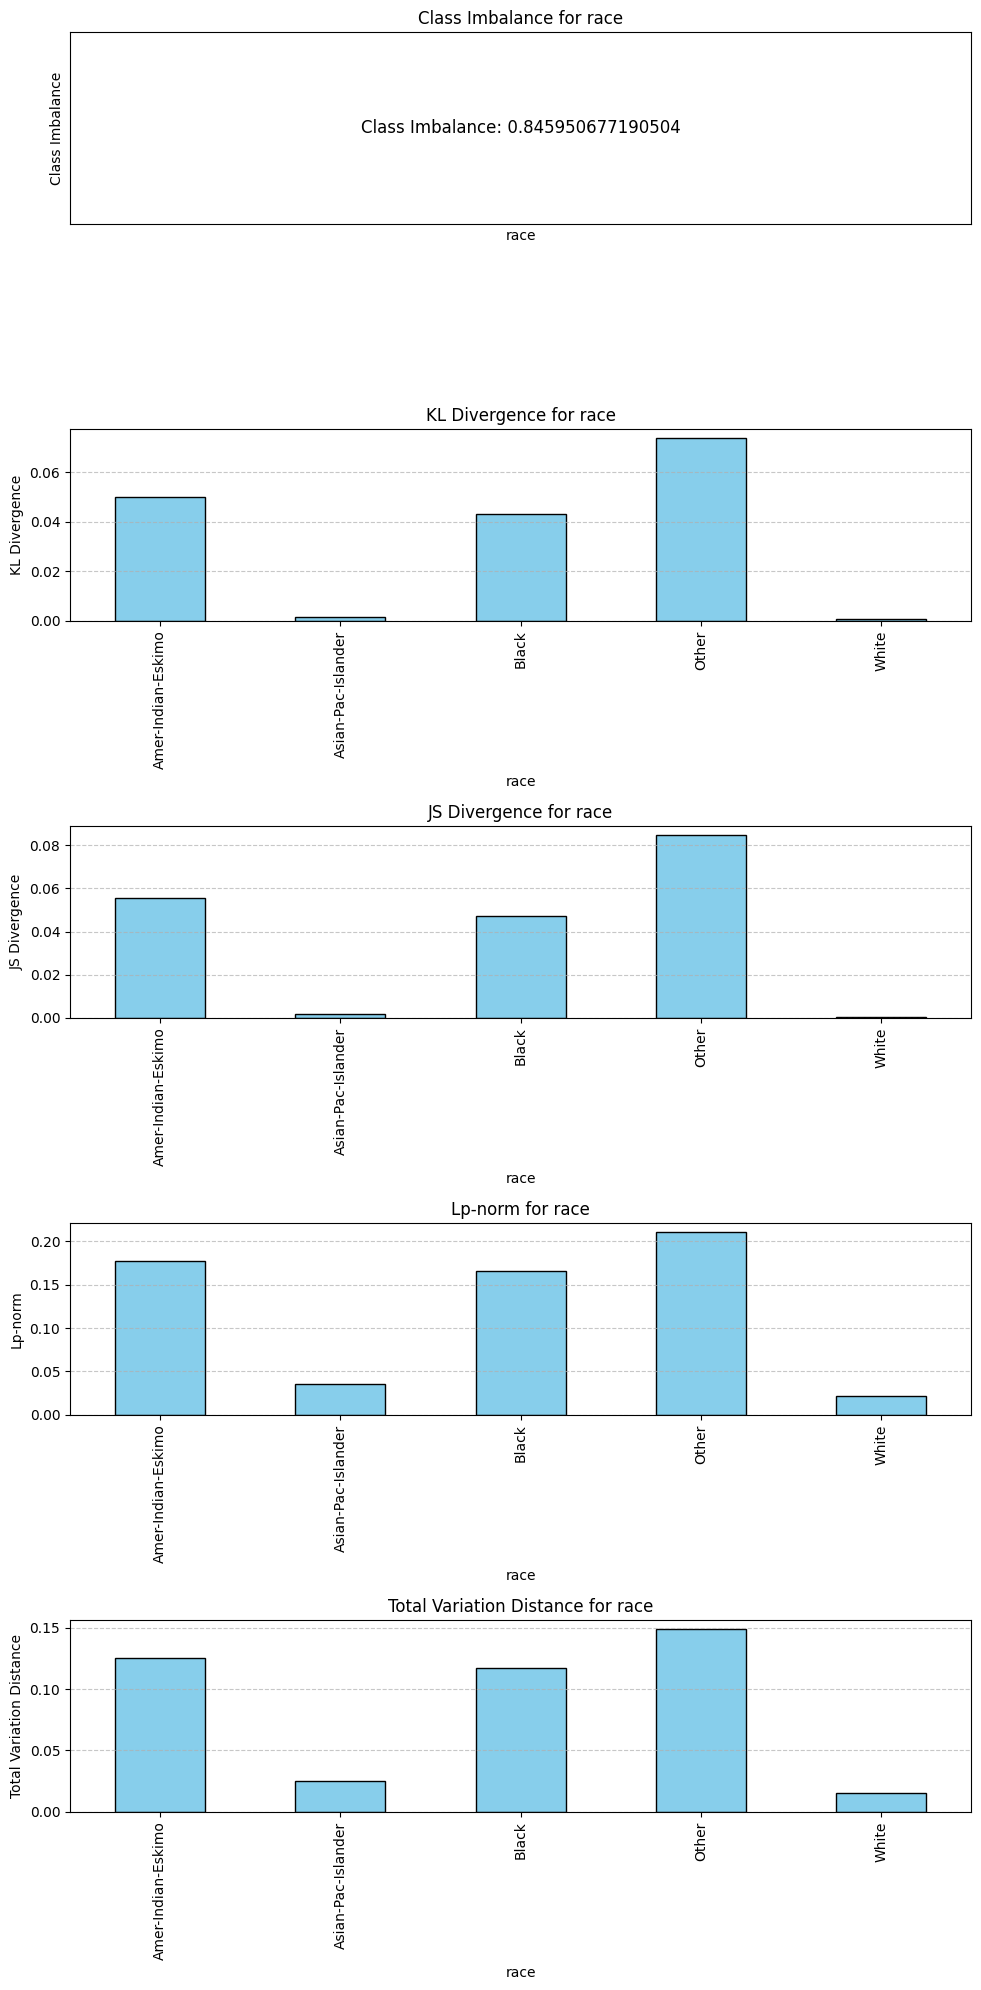

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Load Adult Income Dataset
def load_adult_income_dataset():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    columns = [
        "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
        "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
        "hours_per_week", "native_country", "income"
    ]
    df = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
    df = df.dropna()
    return df

# Compute Pre-training Bias Metrics
def compute_bias_metrics(df, feature, target):
    metrics = {}

    # Class Imbalance
    class_counts = df[feature].value_counts(normalize=True)
    metrics['Class Imbalance'] = class_counts.max() - class_counts.min()

    # Kullback-Leibler Divergence (KL)
    overall_dist = df[target].value_counts(normalize=True)
    group_distributions = df.groupby(feature)[target].value_counts(normalize=True).unstack(fill_value=0)
    kl_divergence = group_distributions.apply(lambda row: entropy(row, overall_dist), axis=1)
    metrics['KL Divergence'] = kl_divergence

    # Jensen-Shannon Divergence (JS)
    js_divergence = group_distributions.apply(
        lambda row: 0.5 * entropy(row, overall_dist) + 0.5 * entropy(overall_dist, row), axis=1
    )
    metrics['JS Divergence'] = js_divergence

    # Lp-norm (LP)
    lp_norm = group_distributions.apply(lambda row: np.linalg.norm(row - overall_dist, ord=2), axis=1)
    metrics['Lp-norm'] = lp_norm

    # Total Variation Distance
    tv_distance = group_distributions.apply(lambda row: np.abs(row - overall_dist).sum() / 2, axis=1)
    metrics['Total Variation Distance'] = tv_distance

    return metrics

# Plot Bias Metrics
def plot_bias_metrics(metrics, feature):
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 20))
    for idx, (metric_name, values) in enumerate(metrics.items()):
        ax = axes[idx]
        # Check if the values are a Pandas Series before plotting
        if isinstance(values, pd.Series):
            values.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
        else:
            # Handle the case where values are not plottable (e.g., Class Imbalance)
            ax.text(0.5, 0.5, f"{metric_name}: {values}", ha='center', va='center', fontsize=12)
            ax.set_xticks([])  # Remove x-axis ticks if not plotting
            ax.set_yticks([])  # Remove y-axis ticks if not plotting

        ax.set_title(f"{metric_name} for {feature}")
        ax.set_ylabel(metric_name)
        ax.set_xlabel(feature)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Main Execution
df = load_adult_income_dataset()
feature = 'race'
target = 'income'
bias_metrics = compute_bias_metrics(df, feature, target)
plot_bias_metrics(bias_metrics, feature)


W can observe a value of **0.845**, which  indicates a high level of class imbalance for the 'race' feature. This means one or a few racial groups are heavily overrepresented compared to others.